# PHYS3151 Course Project

Name: Ngan Tsz Chun (John), So Kwun Ching (Sammi)

## 1. Background information
### 1.1 Ising Model

In this section, we are going to construct a lattice. First of all, we generate a lattice of dimension $ N = L\times L$ with random spin configuration. To generate the spins ($+1$ or $-1$), we take the sign of the random float from $-0.5$ to $+0.5$.

In [1]:
import numpy as np
import random

#Generate a lattice of size L*L with random spin configuration
#Generate random float from 0 to 1, then minus 0.5, then take the sign
def lattice(L):
    Config = np.zeros((L,L), dtype=int)
    for i in range(L):
        for j in range(L):
            Config[i,j] = np.sign(np.random.rand()-0.5)
    return Config

### 1.2 Physics Observables

In this section, we are going to construct model for the expected value of magnetization, specific heat and susceptibility of the system.
The magnetization is defined as the sum of the magnetization of each configuration divided by the size of the lattice.

The energy of the whole lattice $E$ is given by the sum of the interactions of the spins with their nearest neighbors.

In [2]:
#Calculate the energy of the configuration
def Energy(Config,L):
    E = 0
    for i in range(L):
        for j in range(L):
            S1 = Config[i,j]
            S2 = Config[(i+1)%L, j] + Config[i,(j+1)%L] + Config[(i-1)%L,j] + Config[i,(j-1)%L]
            E += -S1*S2 
    return E

The magnetization of the lattice $m$ is defined as the sum of spins divided by the dimension of the lattice $N$.

In [3]:
#Calculate the magnetization of the configuration
def Magnetization(Config,L):
    m = np.sum(Config)/(L*L)
    return m

On the other hand, the value of specific heat $C$ is defined as the expected value of square of energy $E$ minus the square of the expected value of $E$ divided by the multiplication of $N$ and square of temperature $T$, where $N$ is the size of the lattice. 

In [4]:
#Calculate the specific heat of the expected value of energy
def Specific_Heat(E_list,L,T):
    return (np.mean([i**2 for i in E_list])-np.mean(E_list)**2)/(L*T)**2

Similarly, the susceptibility $\chi$ is given by the sum of the configurations divided by the multiplication of $N$ and temperature $T$, where $N$ is the size of the lattice.

In [5]:
#Calculate the Susceptibility of the sum of spin in a configuration
def Susceptibility(M_list,N,T):
    return (np.mean([i**2 for i in M_list])-np.mean(M_list)**2)/(N*T)

## 1.3 Monte Carlo Simulation

In the section, we perform the Metropolis algorithm for the Monte Carlo Simulation. 
The first step is to set up the lattice which we did in the first section. The second step is to randomly select a spin and perform the flip to observe the change in energy dE due to the flip and the probability. To flip the spin, we multiply $-1$ to the spin. If the change in energy is smaller than zero, we accept the flip. Otherwise, if the probability is equals to the exponential function of $-dE$ divided by the temperature, we accept the flip.

In [6]:
#The Metropolis algorithm for Monte Carlo simulation
def Metropolis(Config,L,T):
    for a in range(L):
        for b in range(L):
                i = np.random.randint(0, L)
                j = np.random.randint(0, L)
                S1 = Config[i,j]
                S2 = Config[(i+1)%L, j] + Config[i,(j+1)%L] + Config[(i-1)%L,j] + Config[i,(j-1)%L]
                dE = 2*S1*S2
                if dE < 0:
                    S1 *= -1
                elif np.random.rand() < np.exp(-dE/T):
                    S1 *= -1
                Config[i, j] = S1
                
    return Config

After $N$th times of the above steps, we will finish one Monte Carlo iteration and we will compute the physical observables.

## 2. Project content

This section contains the main loop of the project to answer to question. 

### Question 1
For question 1, we are asked to plot the dynamics of any observables and show that the observable converges after certain steps with only a small thermal fluctuation. Energy have been chosen as the physical observable. The main loop was coded as below:

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def Q1(L,Mcstep,t1):
    
    #size of the configuration
    N = L*L
 
    E_T_list = []
    
    init_state = lattice(L)
    for k in range(Mcstep):
        MC = Metropolis(init_state,L,t1)
        E_T_list.append(Energy(MC,L))
           
    plt.figure(figsize=(6, 5))
    plt.scatter(np.linspace(0, Mcstep, Mcstep,endpoint=False),E_T_list)
    plt.xlabel("iterations")
    plt.ylabel("E")         
    plt.title("E vs iterations at T = "+str(t1))

For question 1, a $16 \times 16$ lattice was chosen, the loop is looped through $2000$ times and the temperature chosen was $1$.

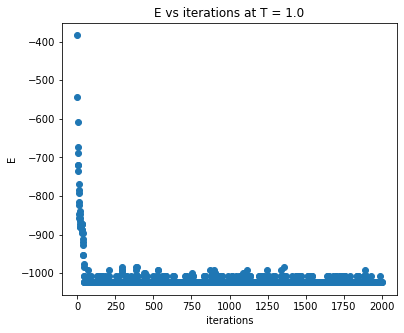

In [14]:
Q1(L=16,Mcstep=2000,t1=1.)

From the graph, it can been seen that energy converges rapidly from $-400$ to below $-1000$ at around $100$th iterations. Although few fluctuations are present, the value of energy stays roughly the same after some iterations.

## Question 2 & 3

For question 2 and 3, we are asked to plot expectation values of the physical observables mentioned above against temperature $T$ with error bars, and perform logistic regression to determine the Ising phase transition point $T_C$.

### Logistic Regression

Logistic Regression will be used to determine the Ising phase transition point $T_C$. The expectation value of the absolute value of magnetization $<|m|>$ will be used to perform logistic regression, where it will be classified into ordered phase and disordered phase with the decision boundary of 0.5. The slope of the decision boundary after gradient descent of the temperature will then be the Ising phase transition point $T_C$. Below is the code of logistic regression using the gradient descent method.

In [9]:
#Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Cost function
def computeCost(theta,X,y):
    
    m = float(len(y))
    
    predictions = sigmoid(X.dot(theta))
    cost = -(1/m) * (y.T.dot(np.log(predictions))+(1-y).T.dot(np.log(1-predictions)))
    return cost

In [10]:
#logistic regression
def LogisticRegression(T,x,L):
    
    #prepare data
    y = []
    #decision boundary
    for i in x:
        if i>=0.5:
            y.append(1)
        else:
            y.append(0)

    alpha =0.01
    iterations =100000

    
    T_b = np.c_[np.ones((len(T),1)),T]
    theta = np.zeros((T_b.shape[1],1))
    y = np.array(y)
    y = y.reshape((len(y),1))

    
    #gradient descent
    m = float(y.shape[0])
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,T_b.shape[1]))
    for i in range(iterations):
        prediction = sigmoid(T_b.dot(theta))
        theta = theta -(1/m)*alpha*(T_b.T.dot((prediction - y)))
        theta_history[i,:] = theta.T
        cost_history[i]  = computeCost(theta,T_b,y)   
    
    print('Cost history of L =',L,':\n',cost_history)
    #Determine the Ising phase transition point
    T_c = -(theta[0][0]/theta[1][0])
    print('T_c for L =',L,'is', T_c)

The code below is the main loop of question 2 and 3. Firstly, Monte Carlo simulation will be repeated until the lattice reaches equilibrium state, where physic observables will be converged as shown in question 1. Next, physic observables will be recorded for each iteration, and the expectation value of them will be recorded every 1000 iterations to ensure that the data is statistically independent, as their distribution is not Gaussian. After the iterations is completed. The total expectation value and standard deviation will be computed using the expectation values mentioned above. This loop will be repeated for each selected temperature point. 

After iteration for a range of temperature is finished, the list of $<|m|>$ for each temperature point will be used to perform logistic regression and find out $T_C$.

After $T_C$ of that particular lattice size $L$ was determined, the code will be looped again with other $L$, until all $T_C$ for different $L$ have been determined. Using the values of the physical observables stored in each loop for different $L$, graph of $<|m|>,<m^2>, <E>/N, <C>, <\chi>$ against temperature $T$ with standard deviation of them as error bars.

In [11]:
import matplotlib.pyplot as plt
import time
%matplotlib inline

def Project(L_list,Mcstep,plot):
    
    #iterations until it reaches equilibrium state
    Equstep = 1000
    #maximum temperature
    tmax = 4.
    #minimum temperature
    tmin = 1.
    #number of temperature points
    tp = 40
    #temperature
    T = np.linspace(tmin,tmax,tp)
    
    #setting up lists
    E_N_expect_L = []
    m_abs_expect_L = []
    m_sq_expect_L = []
    C_expect_L = []
    X_expect_L = []
    E_N_std_L = []
    m_abs_std_L = []
    m_sq_std_L = []
    C_std_L = []
    X_std_L = []
    
    #for each lattice size
    for L in L_list:
        #record start time of the loop
        start_time = time.time()
        
        #size of the configuration
        N = L*L
    
        #reset lists
        E_expect_tp = []
        m_abs_expect_tp = []
        m_sq_expect_tp = []
        E_std_tp = []
        m_abs_std_tp = []
        m_sq_std_tp = []
        C_expect_tp = []
        X_expect_tp = []
        C_std_tp = []
        X_std_tp = []

        #for each temerature point
        for i in range(tp):
            #reset lists
            E_expect = []
            m_abs_expect = []
            m_sq_expect = []
            C_list = []
            X_list = []

            Config = lattice(L)
            #perform metropolis algorithm until it reaches equilibrium state
            for j in range(Equstep):         
                MC = Metropolis(Config,L,T[i])
                #setting up lists
                M_list = []
                E_list = []
                m_list = []

            #perform metropolis algorithm to collect data
            for k in range(Mcstep):
                MC = Metropolis(Config,L,T[i])
                #Sum of Spin M
                M_list.append(np.sum(MC))
                #Energy E
                E_list.append(Energy(MC,L)) 
                #Magnitization m
                m_list.append(Magnetization(MC,L))

                #binning
                if k%1000 ==0 and k!=0:
                    #<E> per bin
                    E_expect.append(np.mean(E_list))         
                    #<|m|> per bin
                    m_abs_expect.append(np.mean([abs(i) for i in m_list]))
                    #<m^2> per bin
                    m_sq_expect.append(np.mean([i**2 for i in m_list]))
                    #Specific Heat C per bin
                    C_list.append(Specific_Heat(E_list,L,T[i]))
                    #Susceptibility X per bin
                    X_list.append(Susceptibility(M_list,N,T[i]))

                    #reset the list
                    M_list = []
                    E_list = []
                    m_list = []

            #<E> per temperature point
            E_expect_tp.append(np.mean(E_expect))
            #<|m|> per temperature point
            m_abs_expect_tp.append(np.mean(m_abs_expect))
            #<m^2> per temperature point
            m_sq_expect_tp.append(np.mean(m_sq_expect))
            #<C> per temperature point
            C_expect_tp.append(np.mean(C_list))
            #<X> per temperature point
            X_expect_tp.append(np.mean(X_list))

            #standard deviation of E per temperature point
            E_std_tp.append(np.std(E_expect, ddof = 1))
            #standard deviation of |m| per temperature point
            m_abs_std_tp.append(np.std(m_abs_expect, ddof = 1))
            #standard deviation of m^2 per temperature point
            m_sq_std_tp.append(np.std(m_sq_expect, ddof = 1))
            #standard deviation of C per temperature point
            C_std_tp.append(np.std(C_list, ddof = 1))
            #standard deviation of X per temperature point
            X_std_tp.append(np.std(X_list, ddof = 1))
            
            #check progress
            if (i+1)%10 == 0 and i!=0:
                print(str(i+1)+" temperature point(s) finished")
            
        #perform Logsitic Regression to find out T_c 
        LogisticRegression(T,m_abs_expect_tp,L)
        
        #<E>/N per L
        E_N_expect_L.append([i/N for i in E_expect_tp])
        #<|m|> per L
        m_abs_expect_L.append(m_abs_expect_tp)
        #<m^2> per L
        m_sq_expect_L.append(m_sq_expect_tp)
        #<C> per L
        C_expect_L.append(C_expect_tp)
        #<X> per L
        X_expect_L.append(X_expect_tp)

        #standard deviation of E/N per L
        E_N_std_L.append([i/N for i in E_std_tp])
        #standard deviation of |m| per L
        m_abs_std_L.append(m_abs_std_tp)
        #standard deviation of m^2 per L
        m_sq_std_L.append(m_sq_std_tp)
        #standard deviation of C per L
        C_std_L.append(C_std_tp)
        #standard deviation of X per L
        X_std_L.append(X_std_tp)
        
        #time used for the loop for each L
        print("computing time for L="+str(L)+": %s seconds" % (time.time() - start_time))
    
    #plot data
    if plot == True:
        f = plt.figure(figsize=(20, 27))     

        #<E> / N vs Temperature graph
        sp =  f.add_subplot(3,2,1)
        for i in range(len(L_list)):
            plt.errorbar(T, E_N_expect_L[i],yerr=E_N_std_L[i], fmt='o',label="L="+str(L_list[i]))
        plt.xlabel("Temperature", fontsize=25)
        plt.ylabel("<E> / N", fontsize=25)        
        plt.title("<E> / N vs Temperature graph", fontsize=25)
        plt.legend()
        
        #<|m|> vs Temperature graph
        sp =  f.add_subplot(3,2,2)
        for i in range(len(L_list)):
            plt.errorbar(T, m_abs_expect_L[i],yerr=m_abs_std_L[i], fmt='o',label="L="+str(L_list[i]))
        plt.xlabel("Temperature", fontsize=25) 
        plt.ylabel("<|m|>", fontsize=25)   
        plt.title("<|m|> vs Temperature graph", fontsize=25)
        plt.legend()
        
        #<m^2> vs Temperature graph
        sp =  f.add_subplot(3,2,3)
        for i in range(len(L_list)):
            plt.errorbar(T, m_sq_expect_L[i], yerr= m_sq_std_L[i], fmt='o',label="L="+str(L_list[i]))
        plt.xlabel("Temperature", fontsize=25); 
        plt.ylabel("<m^2>", fontsize=25)   
        plt.title("<m^2> vs Temperature graph", fontsize=25)
        plt.legend()
        
        #<C> vs Temperature graph
        sp =  f.add_subplot(3,2,4)
        for i in range(len(L_list)):
            plt.errorbar(T, C_expect_L[i], yerr=C_std_L[i], fmt='o',label="L="+str(L_list[i]))
        plt.xlabel("Temperature", fontsize=25) 
        plt.ylabel("<C>", fontsize=25)    
        plt.title("<C> vs Temperature graph", fontsize=25)
        plt.legend()
        
        #<X> vs Temperature graph
        sp =  f.add_subplot(3,2,5)
        for i in range(len(L_list)):
            plt.errorbar(T, X_expect_L[i],yerr=X_std_L[i], fmt='o',label="L="+str(L_list[i]))
        plt.xlabel("Temperature", fontsize=25) 
        plt.ylabel("<X>", fontsize=25)
        plt.title("<X> vs Temperature graph", fontsize=25)
        plt.legend()
        
        plt.show()

In this project, lattice size of $L=4,8,12,16$ was chosen, and the result is shown below

10 temperature point(s) finished
20 temperature point(s) finished
30 temperature point(s) finished
40 temperature point(s) finished
Cost history of L = 4 :
 [0.690657   0.68825941 0.68595075 ... 0.11198189 0.11198147 0.11198106]
T_c for L = 4 is 3.3351775703576676 K
L=4: 117.81553912162781 seconds
10 temperature point(s) finished
20 temperature point(s) finished
30 temperature point(s) finished
40 temperature point(s) finished
Cost history of L = 8 :
 [0.69247299 0.69181836 0.69118251 ... 0.09340282 0.09340248 0.09340215]
T_c for L = 8 is 2.637143379368679 K
L=8: 446.05894708633423 seconds
10 temperature point(s) finished
20 temperature point(s) finished
30 temperature point(s) finished
40 temperature point(s) finished
Cost history of L = 12 :
 [0.69168091 0.69026566 0.68889944 ... 0.09006686 0.09006653 0.09006621]
T_c for L = 12 is 2.4836911282368956 K
L=12: 977.3664782047272 seconds
10 temperature point(s) finished
20 temperature point(s) finished
30 temperature point(s) finished
40 

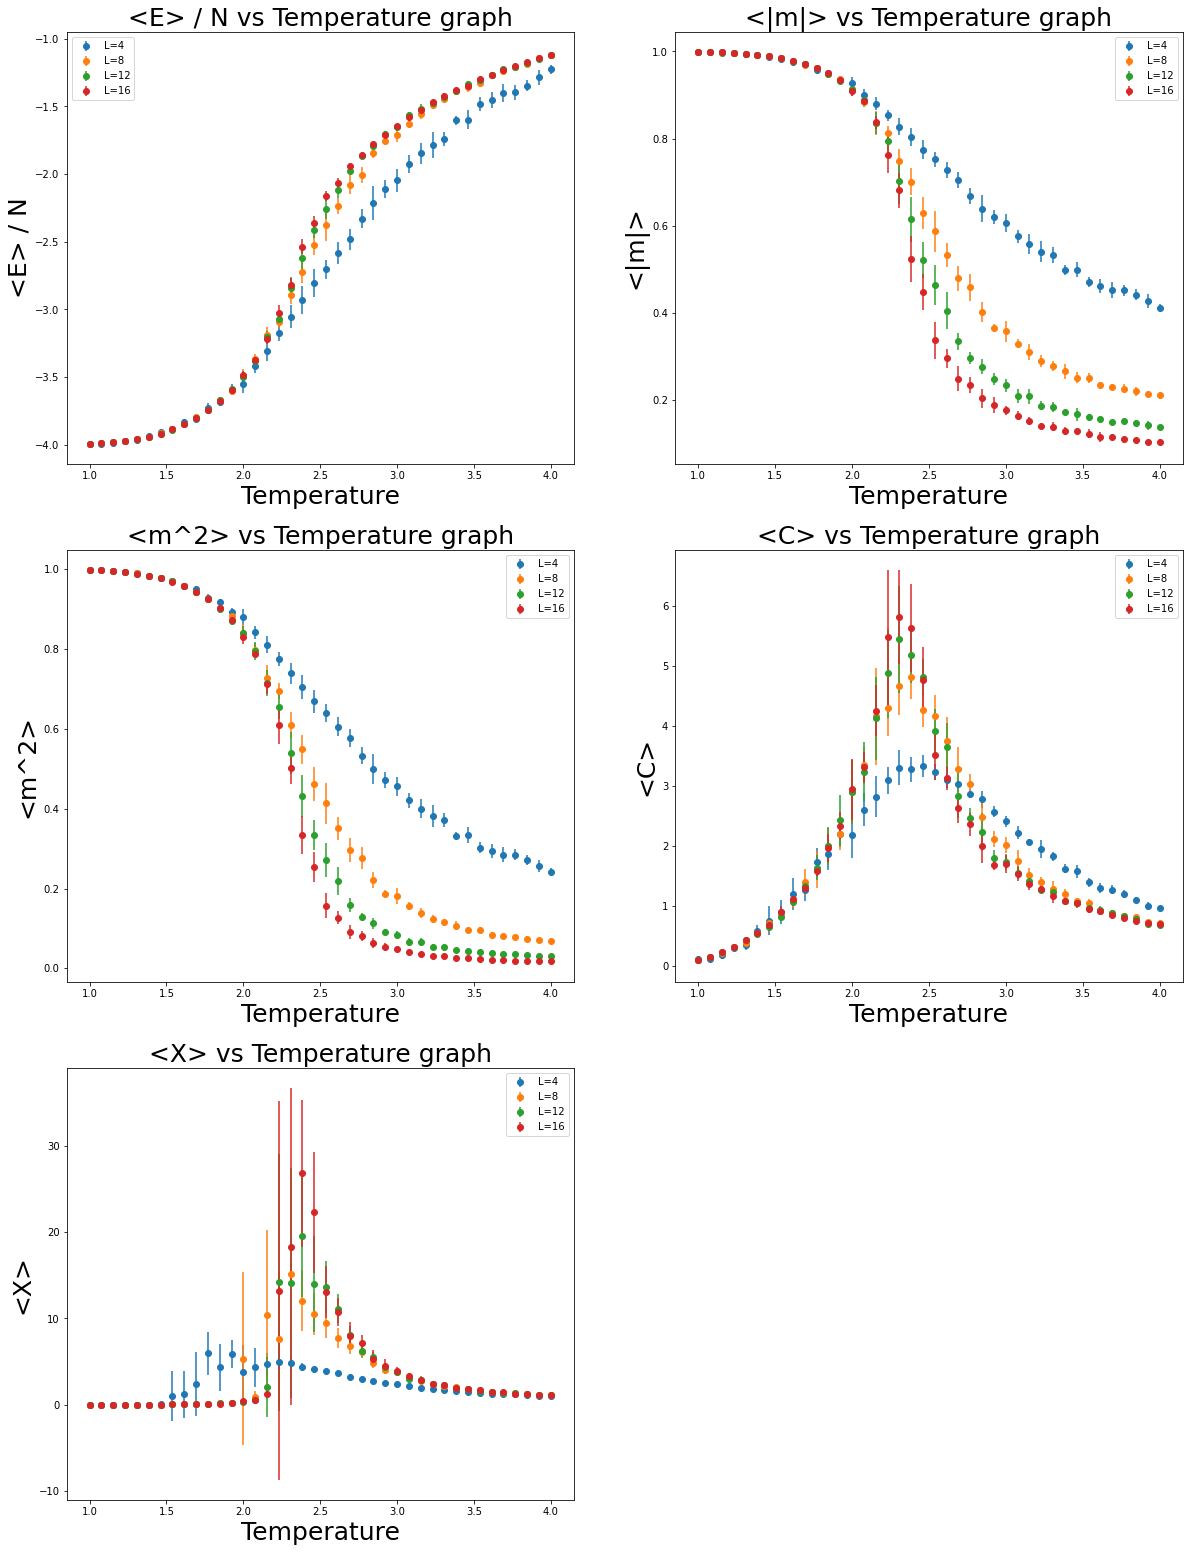

In [12]:
#For L=4,8,12,16
L_list = [4,8,12,16]
Project(L_list,10000,True)

Using the data above, it is concluded that 
$$For L=4, T_C=3.3351775703576676$$
$$For L=8, T_C=2.637143379368679$$
$$For L=12, T_C=2.4836911282368956$$
$$For L=16, T_C=2.4069672673711593$$

We could see that as the lattice size increase, the Ising phase transition point $T_C$ will be closer to the correct value of $T_C\approx2.269$ (Onsager, 1944). The cost also decrease when the lattice size increase as well, meaning that there are fewer error in the value of $T_C$. This is because as the lattice size increase, it is more similar to the real life. 

## Limitations
As $|m|\sim|T-T_C|^\beta$ which is a power law (Marchand, 2005), it would be difficult for the Sigmoid function to be able to fit into this equation.

The error bar of the physical observable become large when the temperature is close to the critical point as it is limited by the Metropolis algorithm.

## Improvements
To further lower the value of computed $T_C$, larger lattice size, more iterations, and more temperature points can be computed for a more accurate representation of the system, so that $T_C$ will be closer to the exact value.

To lower the computed time, the code need to be further optimized. Smaller bin size may improve the time as the list would store fewer data.

To reduce the error bar of physical observables when near critical temperature, other algorithm can be used such as cluster algorithm, where spin with the same sign will be grouped as a cluster and will be flipped at once, so that it will be scale invariant, and the standard deviation during transition can be reduced.

In this project, it is assumed that after 1000 Monte Carlo simulation iterations, the new configuration would be statistically independent from the previous configuration. In order to check whether this is correct, we can perform autocorrelation functions to make sure that they are statistically independent(Marchand, 2005).

The power law above can be used to deduce the critical temperature instead of logistic regression, so that it will fit the graph better than the sigmoid function(Marchand, 2005).

## Conclusion
In conclusion, using metropolis algorithm to perform Monte Carlo Simulation on two dimensional Ising model, it is determined that the the Ising phase transition point $T_C$ for $L=4,8,12,16$ are $3.3351775703576676,2.637143379368679,2.4836911282368956,2.4069672673711593$ respectively.

## Reference
Marchand, D. (2005). Classical monte carlo and the metropolis algorithm: Revisiting the 2d ising model. University of British Columbia, Department of Physics and Astronomy.

Onsager, L. (1944). Crystal Statistics. I. A Two-Dimensional Model with an Order-Disorder Transition. *Phys. Rev., 65*(3-4), 117-149. https://doi.org/10.1103/PhysRev.65.117